In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Data3461_solutions/Labs/Lab.7/A.StyleTransfer"

/content/drive/MyDrive/Data3461_solutions/Labs/Lab.7/A.StyleTransfer


# Assignment - 7- A
## Neural Style Transfer

## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

## Tasks

1. Import the content image and style image using below given code.
2. Perform standard preprocessing ( Convrting dtype of image, resize and adding batch dimension)
3. Write functions to calculate Style loss, content loss and total variation loss and gram matrix.
4. Import pretrained VGG/Resnet Model. We will be using this to extract embedding for content and style images. Set trainable to False.
5. Select layers for extracting content and style information. For VGG19, a typical combination is provided below. Feel free to experiment with different layers.
6. Perform model training with number of epochs set to higher number(Ex- 5000's). Use early stopping call back to monitor loss and stop if there is no improvement in performance. (Ex- When decrement is loss is less than 50 , then stop)
7. Print the final transformed image along side content and style image.
8. Now consider any other example set ( Your own set of content and style images ). Pass it through the network without training and print the resultant image.

Ref- https://arxiv.org/abs/1508.06576

## Note -

Change the runtime type to T4 GPU on your colab. Without GPU , the model takes much longer.

In [3]:
nightcanvas_image="https://cdn.britannica.com/78/43678-050-F4DC8D93/Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg"
dog_image= "https://kb.rspca.org.au/wp-content/uploads/2018/11/golder-retriever-puppy.jpeg"

In [4]:
from google.colab import files as FILE
import requests

img_data = requests.get(nightcanvas_image).content
with open('nightcanvas_image.jpg', 'wb') as handler:
    handler.write(img_data)

img_data = requests.get(dog_image).content
with open('dog.jpeg', 'wb') as handler:
    handler.write(img_data)

In [5]:
content_image_path = 'dog.jpeg'
style_image_path = 'nightcanvas_image.jpg'

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

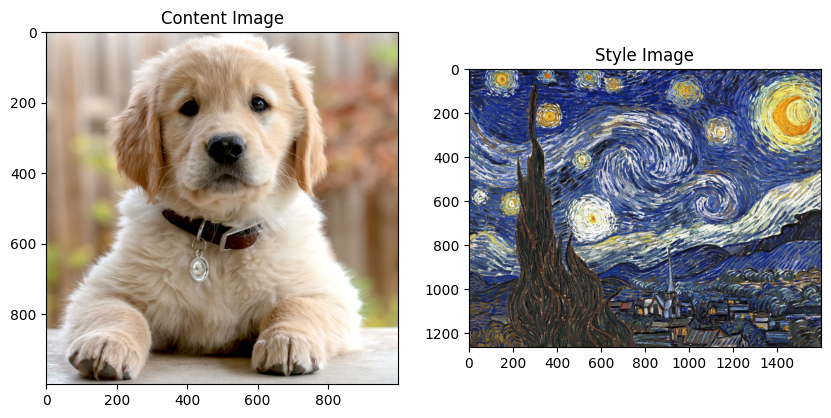

In [7]:
# Load the content and style images
content = plt.imread(content_image_path)
style = plt.imread(style_image_path)

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()


In [8]:
## Content and Style layers when you are trying Resnet
# Content layer
content_layers = ['conv1_conv']

# Style layer
style_layers = ['conv2_block1_2_bn',
                'conv3_block1_1_bn',
                'conv3_block2_1_bn',
                'conv4_block1_2_bn',
                'conv5_block1_2_bn']


## Content and Style layers when you are trying VGG19

style_layer = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer = "block5_conv2"

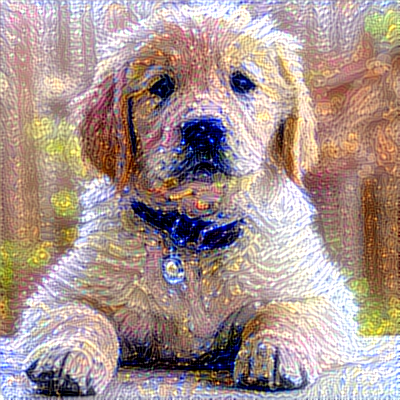

In [9]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

935806/935806 [==============================] - 0s 0us/step


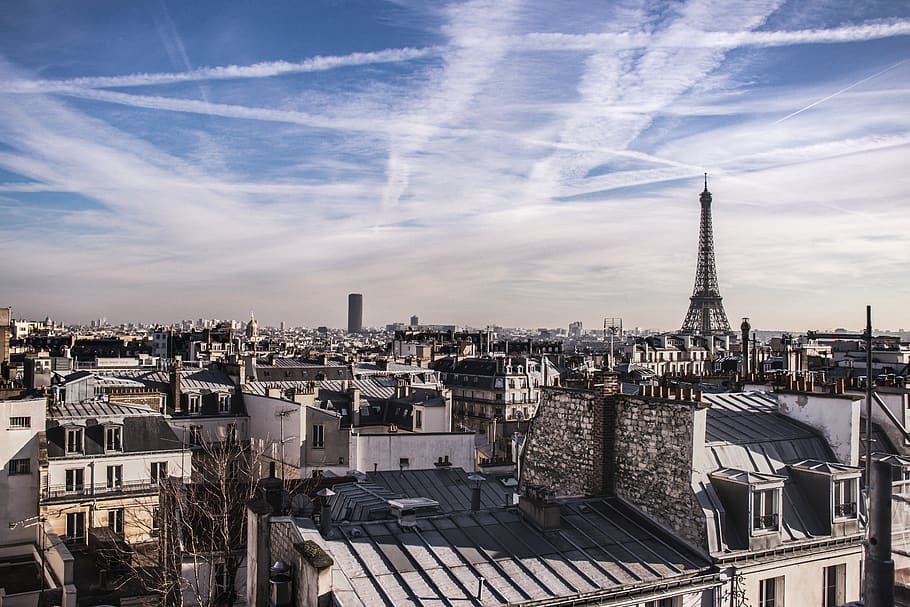

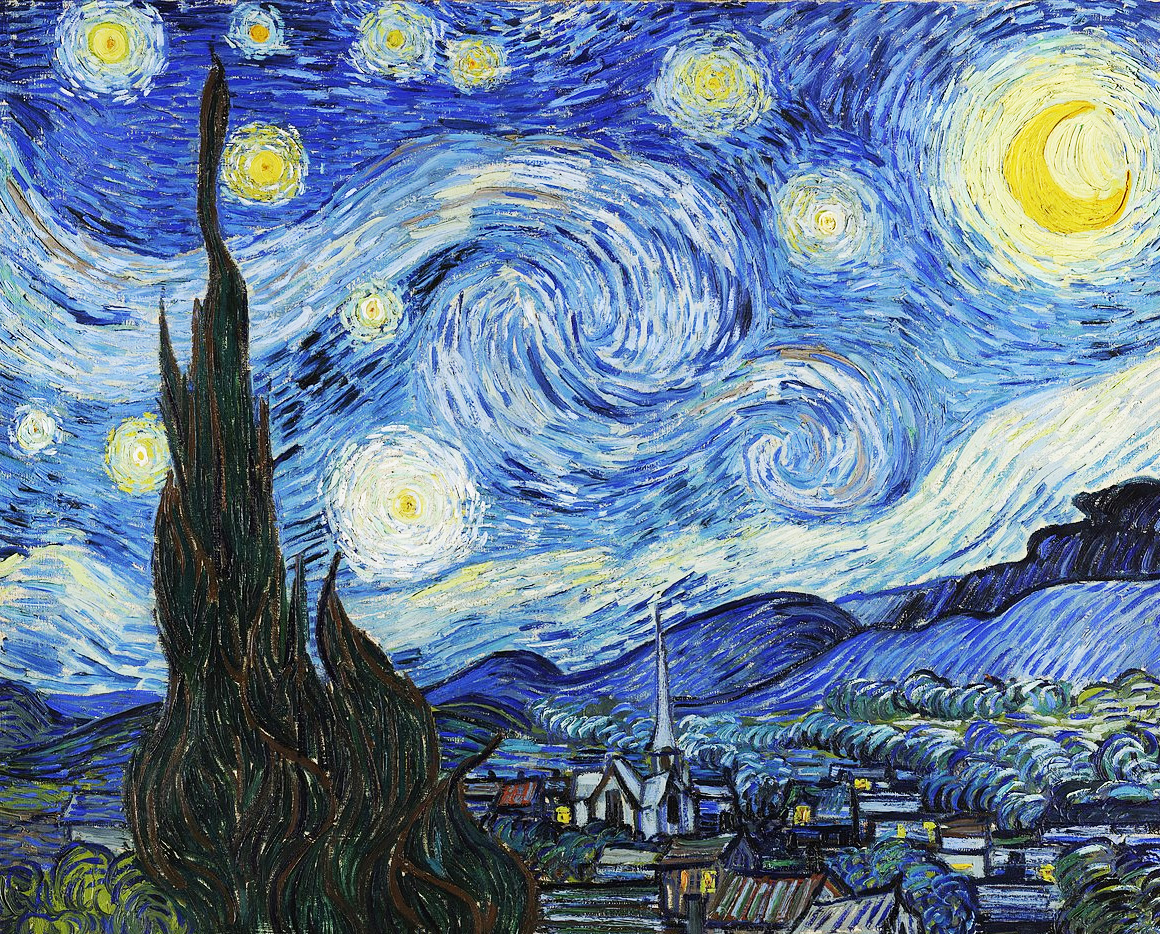

In [10]:
# Look at base image to be modified

from IPython.display import Image, display

display(Image(base_image_path))

# Look at reference imge to lift style from
display(Image(style_reference_image_path))

In [11]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [13]:
'''
Compute the style transfer loss
First, we need to define 4 utility functions:

- gram_matrix (used to compute the style loss)
- The style_loss function, which keeps the generated image close to the local textures of
    the style reference image
- The content_loss function, which keeps the high-level representation of the generated
    image close to that of the base image
- The total_variation_loss function, a regularization loss which keeps the generated
    image locally-coherent
'''

# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

'''
The "style loss" is designed to maintain
the style of the reference image in the generated image.
It is based on the gram matrices (which capture style) of
feature maps from the style reference image
and from the generated image
'''

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

'''
An auxiliary loss function
designed to maintain the "content" of the
base image in the generated image
'''

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

'''
The 3rd loss function, total variation loss,
designed to keep the generated image locally coherent
'''


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


In [14]:
'''
Next, let's create a feature extraction model that retrieves the intermediate activations
    of VGG19 (as a dict, by name).
'''

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 2s 0us/step


In [15]:
'''
Finally, here's the code that computes the style transfer loss.
'''

# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [16]:
'''
Add a tf.function decorator to loss & gradient computation
To compile it, and thus make it fast.
'''

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [17]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [18]:
'''
The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the resulting
image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.
'''



optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=11024.32
Iteration 200: loss=8518.71
Iteration 300: loss=7573.79
Iteration 400: loss=7063.27
Iteration 500: loss=6734.04
Iteration 600: loss=6498.56
Iteration 700: loss=6319.59
Iteration 800: loss=6177.38
Iteration 900: loss=6060.82
Iteration 1000: loss=5963.34
Iteration 1100: loss=5880.40
Iteration 1200: loss=5809.01
Iteration 1300: loss=5746.93
Iteration 1400: loss=5692.52
Iteration 1500: loss=5644.23
Iteration 1600: loss=5601.12
Iteration 1700: loss=5562.40
Iteration 1800: loss=5527.40
Iteration 1900: loss=5495.77
Iteration 2000: loss=5467.10
Iteration 2100: loss=5440.93
Iteration 2200: loss=5417.09
Iteration 2300: loss=5395.28
Iteration 2400: loss=5375.21
Iteration 2500: loss=5356.73
Iteration 2600: loss=5339.64
Iteration 2700: loss=5323.85
Iteration 2800: loss=5309.23
Iteration 2900: loss=5295.63
Iteration 3000: loss=5282.96
Iteration 3100: loss=5271.13
Iteration 3200: loss=5260.06
Iteration 3300: loss=5249.73
Iteration 3400: loss=5240.04
Iteration 3500: loss=5

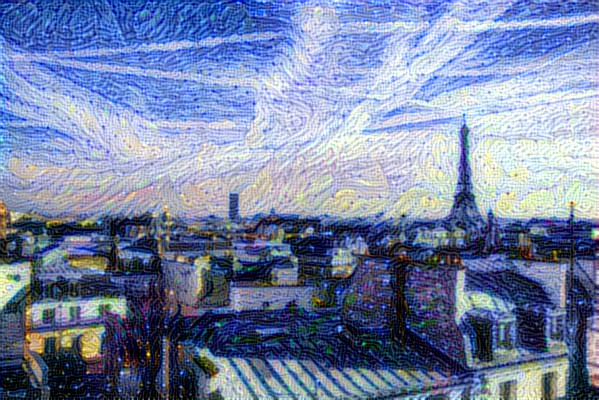

In [19]:
display(Image(result_prefix + "_at_iteration_4000.png"))